In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C://work/dev/python/progs/texts/sec_bert/')

In [3]:
from sklearn.metrics import (average_precision_score, log_loss, confusion_matrix,
                            precision_recall_fscore_support, f1_score)

import matplotlib.pyplot as plt
import seaborn as sns

import os
from ruamel.yaml import YAML
import pandas as pd
import numpy as np
import joblib

from collections import defaultdict
from itertools import chain

import click
import json

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from torch.utils.data import DataLoader, Dataset


from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertConfig, AutoModel
from transformers import DataCollatorWithPadding
from transformers import RobertaTokenizer, RobertaModel

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import sys
sys.path.append('.')
from src.funcs import set_seed
from src.train_eval_model import metric_multi
from src.funcs import get_opt_thresh, get_preds
from src.funcs import get_conf_df



C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from ruamel.yaml import YAML

conf = YAML().load(open('params.yaml'))

conf_dop = YAML().load(open('dvc_pipes/train_bert_emb/params_bert.yaml'))

set_seed(conf['seed'])

In [5]:
class TextDFDataset(Dataset):

    def __init__(self, df, tokenizer, tokenizer_opts):

      self.df = df
      self.tokenizer = tokenizer
      self.tokenizer_opts = tokenizer_opts 
        
    def __getitem__(self, idx):
      # import pdb;pdb.set_trace()
      tok_d = self.tokenizer(self.df.loc[self.df.index[idx], 'sentence'], **self.tokenizer_opts)

      return {**{k:v.flatten() for k,v in tok_d.items()}, **{'target':torch.tensor(self.df.loc[self.df.index[idx], 'target'], dtype=torch.float)}}

    def __len__(self):

      return self.df.shape[0]


class TextModelClass(torch.nn.Module):

    def __init__(self, bert_model, mode, classnum, dropout_ratio):

        super().__init__()
        self.bert = bert_model
        self.mode = mode
        self.lin = torch.nn.Linear(768, 768)
        self.drop_out = torch.nn.Dropout(dropout_ratio)
        self.lin_out = torch.nn.Linear(768, classnum)

    def forward(self, X):

        out = self.bert(**{k: v.to(DEVICE) for k, v in X.items() if k!='target'})
        if self.mode=='cls':
            out = out.last_hidden_state[:,0,:]
        elif self.mode=='pooler':
            out = out.pooler_output
        out = self.lin(out)
        out = torch.nn.ReLU()(out)
        out = self.drop_out(out)
        out = self.lin_out(out)

        return out



In [6]:
TRAIN_BATCH_SIZE = conf_dop['nn']['batch_size']
VALID_BATCH_SIZE = conf_dop['nn']['batch_size']

MAX_SEQ_LENGTH = conf_dop['nn']['maxlen']

DROPOUT_RATIO = conf_dop['nn_bert']['drop_ratio']

mode = conf_dop['nn_bert']['mode'] # pooler

LEARNING_RATE = conf_dop['nn']['learning_rate']
EPOCH_NUM = conf_dop['nn']['epoch_num']

exp_gamma = conf_dop['nn']['exp_gamma'] 
milestone_gamma = conf_dop['nn']['milestone_gamma']
milestone_l = conf_dop['nn']['milestone_l'] 
l2 = conf_dop['nn']['l2']

bert_type = conf_dop['nn_bert']['bert_type']

mlb = joblib.load(conf['prep_text']['mlb_fn'])
data = pd.read_csv(conf['feat_gen']['data_fn'])

data['target'] = data['target'].map(lambda x: eval(x))
data['labels'] = data['labels'].map(lambda x: eval(x))
tr_idx = data.query('split=="tr"').index
val_idx = data.query('split=="val"').index
ts_idx = data.query('split=="ts"').index

In [7]:
if bert_type == 'secbert_plus':
    
    checkpoint = "ehsanaghaei/SecureBERT_Plus"
    tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
    model = RobertaModel.from_pretrained(checkpoint, output_hidden_states=True)
    tokenizer_opts = {'max_length':MAX_SEQ_LENGTH, 'return_tensors':"pt", 'padding':True, 'truncation':True, 'add_special_tokens':True}
    bert_model= model
    
elif bert_type == 'secbert':

    checkpoint = "jackaduma/SecBERT"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    tokenizer_opts = {'max_length':MAX_SEQ_LENGTH, 'return_tensors':"pt", 'padding':True, 'truncation':True, 'add_special_tokens':True}
    config = BertConfig.from_pretrained(checkpoint, output_hidden_states=True)
    bert_model = AutoModel.from_pretrained(checkpoint, config=config).base_model

elif bert_type == 'scibert':
    checkpoint = 'allenai/scibert_scivocab_uncased'
    tokenizer = BertTokenizer.from_pretrained(checkpoint, max_length=512)
    model = BertForSequenceClassification.from_pretrained('scibert_multi_label_model')
    bert_model= model.bert
    tokenizer_opts = {'return_tensors':"pt", 'truncation':True,
                      'padding':'max_length', 'max_length':MAX_SEQ_LENGTH}

Some weights of RobertaModel were not initialized from the model checkpoint at ehsanaghaei/SecureBERT_Plus and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
tr_ds = TextDFDataset(data.query('split=="tr"').reset_index(drop=True), tokenizer =tokenizer, tokenizer_opts=tokenizer_opts)
val_ds = TextDFDataset(data.query('split=="val"').reset_index(drop=True), tokenizer =tokenizer, tokenizer_opts=tokenizer_opts)
ts_ds = TextDFDataset(data.query('split=="ts"').reset_index(drop=True), tokenizer =tokenizer, tokenizer_opts=tokenizer_opts)

tr_ld = DataLoader(tr_ds, batch_size = TRAIN_BATCH_SIZE, shuffle = True, collate_fn = DataCollatorWithPadding(tokenizer=tokenizer))
val_ld = DataLoader(val_ds, batch_size = VALID_BATCH_SIZE, shuffle = False, collate_fn = DataCollatorWithPadding(tokenizer=tokenizer))
ts_ld = DataLoader(ts_ds, batch_size = VALID_BATCH_SIZE, shuffle = False, collate_fn = DataCollatorWithPadding(tokenizer=tokenizer))

In [9]:
model = TextModelClass(bert_model, mode=mode, classnum=len(mlb.classes_), dropout_ratio=DROPOUT_RATIO)
model = model.to(DEVICE)

# Заморозим все слои берта
for param in model.bert.parameters():
    param.requires_grad = False

In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=l2)

scheduler1 = ExponentialLR(optimizer, gamma=conf_dop['nn']['exp_gamma'] )
scheduler2 = MultiStepLR(optimizer, milestones=conf_dop['nn']['milestone_l'], gamma=conf_dop['nn']['milestone_gamma'])

val_iter_num = 1
refresh_cache_iter = 10

loss_d = {}

name = os.path.basename(conf_dop['nn_bert']['model_fn'])
dirname = os.path.dirname(conf_dop['nn_bert']['model_fn'])

if conf_dop['nn_bert']['from_existing']:

    model = torch.load(f'{dirname}/{bert_type}_{name}')
    # saving old one

    os.rename(f'{dirname}/{bert_type}_{name}', f'{dirname}/prev_{bert_type}_{name}')
    

model = model.to(DEVICE)

for epoch in range(1, EPOCH_NUM+1):
    loss_tr_l = []
    model.train()
    res_d = defaultdict(list)
    tr_batch_num = len(tr_ld)
    tr_loss_epoch = 0
    for batch_tr in tr_ld:
        out = model(batch_tr)
        # import pdb;pdb.set_trace()
        optimizer.zero_grad()

        loss = loss_fn(out, batch_tr['target'].to(DEVICE))
        loss.backward()
        optimizer.step()
        tr_loss_epoch = tr_loss_epoch + loss.item()
        with torch.no_grad():
            model.eval()
            res_d['tr_target'].append(batch_tr['target'].numpy()) 
            res_d['tr_pred'].append(out.sigmoid().cpu().numpy()) 

    res_d['tr_target'] = list(chain(*res_d['tr_target']))
    res_d['tr_pred'] = list(chain(*res_d['tr_pred']))
    
    scheduler1.step()
    scheduler2.step()
    
    if epoch%val_iter_num==0:
        model.eval()
        val_batch_num = len(val_ld)
        val_loss_epoch = 0
        pr_auc = 0
        with torch.no_grad():
            for batch_val in val_ld:
                pred = model(batch_val)
                val_loss = loss_fn(pred, batch_val['target'].to(DEVICE))
                val_loss_epoch = val_loss_epoch+val_loss.item()
                sigm_preds = pred.sigmoid().cpu()

                pr_auc = pr_auc + metric_multi(batch_val['target'].numpy(), sigm_preds.numpy(), average_precision_score)[0]

                res_d['target'].append(batch_val['target'].numpy())
                res_d['pred'].append(sigm_preds.numpy())

            res_d['target'] = list(chain(*res_d['target']))
            res_d['pred'] = list(chain(*res_d['pred']))


    loss_d[epoch] = {'log_loss_tr_batch':tr_loss_epoch/tr_batch_num,
                      'log_loss_val_batch':val_loss_epoch/val_batch_num,
                    'pr_auc_batch':pr_auc/val_batch_num,
                     'log_loss_val':metric_multi(np.array(res_d['target']), np.array(res_d['pred']), log_loss)[0],
                    'log_loss_tr':metric_multi(np.array(res_d['tr_target']), np.array(res_d['tr_pred']), log_loss)[0],
                     'pr_auc_val':metric_multi(np.array(res_d['target']), np.array(res_d['pred']), average_precision_score)[0],
                    'pr_auc_tr':metric_multi(np.array(res_d['tr_target']), np.array(res_d['tr_pred']), average_precision_score)[0]}

# Графики ошибок

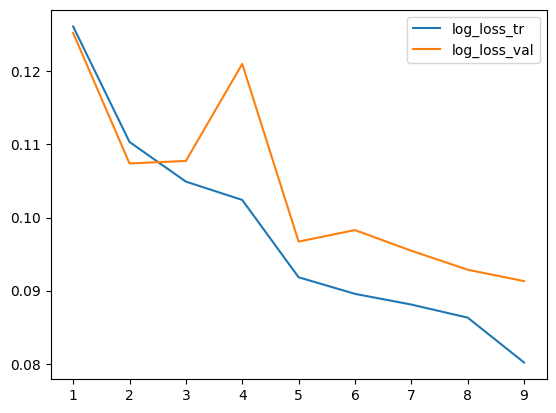

In [11]:
plt.plot(loss_d.keys(),[it['log_loss_tr'] for it in loss_d.values()], label='log_loss_tr')
plt.plot(loss_d.keys(),[it['log_loss_val'] for it in loss_d.values()], label='log_loss_val')
plt.legend()

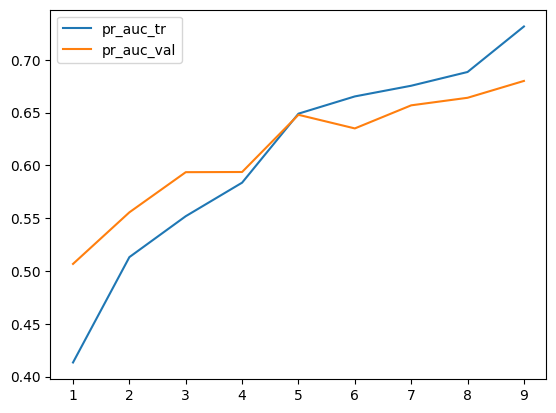

In [12]:
plt.plot(loss_d.keys(),[it['pr_auc_tr'] for it in loss_d.values()], label='pr_auc_tr')
plt.plot(loss_d.keys(),[it['pr_auc_val'] for it in loss_d.values()], label='pr_auc_val')
plt.legend()

# Подбор порога и f1

In [13]:
res_val = get_preds(model, ld=val_ld)

Y_val_proba = np.array(res_val['pred'])
Y_val = np.array(data.loc[val_idx, 'target'].values.tolist())

thresh_l = get_opt_thresh(y_true = Y_val, probas = Y_val_proba, mlb = mlb, opt_metric=conf['train_eval_model']['opt_metric'],
                          dump_fn = conf_dop['nn_bert']['opt_metric_fn'])

res_df = pd.DataFrame()
res_df['y'] = Y_val.tolist()
res_df['y_proba'] = Y_val_proba.tolist()

thresh_col = 'y_p'
res_df[thresh_col] = res_df['y_proba'].map(lambda x: [int(val>=thresh) for val, thresh in zip(x, thresh_l)])

error_df = data.loc[val_idx].reset_index(names='val_idx').join(res_df[['y', 'y_proba', thresh_col]])
error_df['prob_label'] = mlb.inverse_transform(np.array(error_df[thresh_col].tolist()))

p_val_micro, r_val_micro, f1_val_micro, sup = precision_recall_fscore_support(np.array(res_df['y'].values.tolist()), 
                                                    np.array(res_df[thresh_col].values.tolist()), average='micro')
p_val_macro, r_val_macro, f1_val_macro, sup = precision_recall_fscore_support(np.array(res_df['y'].values.tolist()), 
                                                    np.array(res_df[thresh_col].values.tolist()), average='macro')

_, res_l = metric_multi(np.array(error_df['y'].tolist()), np.array(error_df[thresh_col].tolist()), f1_score)

pd.DataFrame({'qual':res_l, 'class':mlb.classes_}).sort_values(by='qual')

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,qual,class
6,0.485294,lateral-movement
12,0.553719,initial-access
13,0.556391,exfiltration
5,0.620290,collection
3,0.643533,persistence
2,0.653465,execution
0,0.671084,defense-evasion
11,0.674157,impact
7,0.675159,credential-access
1,0.675192,privilege-escalation


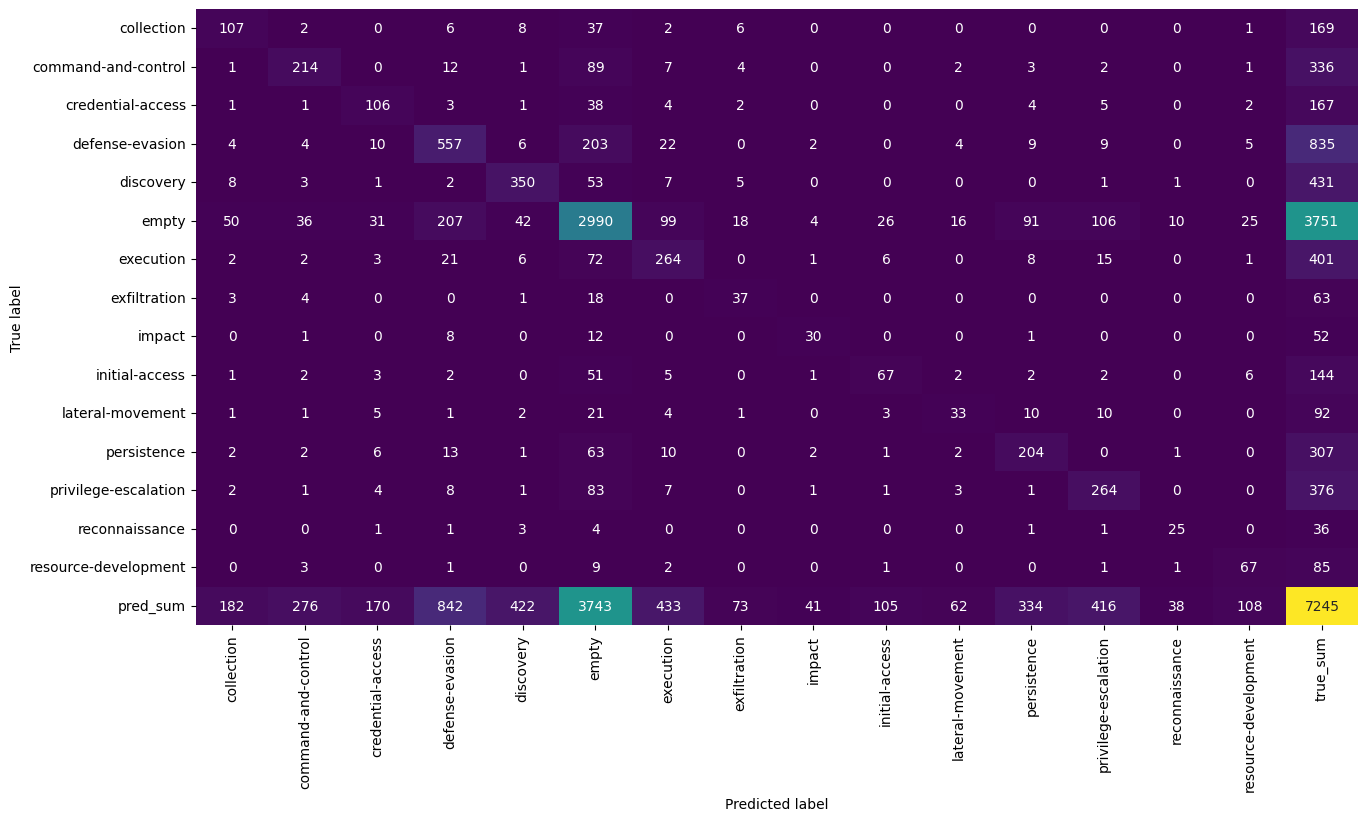

In [14]:
conf_df = get_conf_df(error_df)

plt.figure(figsize=(15,8))

labels = np.sort(conf_df['labels'].unique())
cm = confusion_matrix(y_true = conf_df['labels'], y_pred = conf_df['prob_label'], 
                      labels=labels,
                      normalize=None)

draw_df = pd.concat([pd.DataFrame(cm, index=labels, columns=labels),
                    pd.DataFrame([cm.sum(axis=0)], columns=labels, index=['pred_sum'])])\
            .assign(true_sum=lambda x: x.sum(axis=1))

sns.heatmap(draw_df, annot=True, fmt='d', cmap='viridis', cbar=False)

plt.xlabel('Predicted label')
plt.ylabel('True label');